# Predicting death events from heart failures



### 1. Introduction

##### 1.1 Background

Heart failures or heart diseases are the major cause of death worldwide. In order to handle this problem, healthcare systems are providing progressively more solutions based on technological improvements. One of many of these improvements is the application of Machine Learning modelling. Heart disease (or cardiovascular disease) is being the top disease worldwide, as it’s shown in the table below from OurWorldInData database. Understanding properly and in-time what can cause this phenomena is of a vital importance to tackle it and therefore minimize its effects among the society.

<img src="https://ourworldindata.org/grapher/annual-number-of-deaths-by-cause" loading="lazy" style="width: 100%; height: 600px; border: 0px none;"></img>

##### 1.2 Problem

In order to increase efficiency when healthcare resources are in risk or are scarce, stakeholders of healthcare enterprises would choose better systems of diagnosis and prevention. Machine Learning models are suitable for this purpose and have demonstrated several positive results. In times of COVID-19 pandemic different healthcare systems have systematically failed, sometimes showing a lack of coordination or bad Database Management Systems (DBMS).

### 2. Data acquisition and Cleansing

##### 2.1 Data source

The data was gotten from Kaggle.com, but originally the data was provided by UCI (University of California, Irvine) from the paper "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone" (Chicco & Jurman, 2020).

In [20]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing


df = pd.read_csv('heart_failure_dataset.csv') 
df.rename(columns={'Event':'DEATH_EVENT','Gender':'Sex','BP':'Blood_pressure',
                   'Ejection.Fraction':'Ejection_fraction','Pletelets':'Platelets'},inplace=True)
df.drop(columns=['TIME'],inplace=True)

##### 2.1 Data cleansing

The data had originally 13 features, with no missing data points. These features are: age of the patient, anaemia (dummy variable), high blood pressure (dummy variable), creatinine phosphokinase (CPK) : level of the CPK enzyme in the blood (mcg/L), diabetes: if the patient has diabetes (dummy variable), ejection fraction: percentage of blood leaving the heart at each contraction (percentage), platelets: platelets in the blood (kiloplatelets/mL), sex: woman or man (dummy variable), serum creatinine: level of serum creatinine in the blood (mg/dL), serum sodium: level of serum sodium in the blood (mEq/L), smoking: if the patient smokes or not (dummy variable), time: follow-up period (days), [target] death event: if the patient deceased during the follow-up period (dummy variable). It has to be said that this is a small dataset with just 300 observations, nevertheless, the features are relevant and with no missing values as pointed out earlier.
The main problems when data cleansing techniques are applied is the different measurement of the features. This can be a problem when Classification Algorithms are applied. Dummy variables are already ‘scaled’ in a sense, but continuous variables as platelets in the blood or serum creatinine are not. Therefore, Scaling technique was applied to the following variables:

-	creatinine phosphokinase (CPK).
-	serum sodium
-	platelets: platelets in the blood (kiloplatelets/mL)
-	serum creatinine
-	age

The Scaling formula applied was:

$$X=\frac{X-X_{Min}}{X_{Max}-X_{Min}}$$

In [2]:
#Missing values
df.isnull().any(axis = 1).sum()


0

In [3]:
#Data_cleansing of continuous variables
df['Age'] = (df['Age'] - df['Age'].min())/(df['Age'].max()-df['Age'].min())
df['CPK'] = (df['CPK'] - df['CPK'].min())/(df['CPK'].max()-df['CPK'].min())
df['Sodium'] = (df['Sodium'] - df['Sodium'].min())/(df['Sodium'].max()-df['Sodium'].min())
df['Platelets'] = (df['Platelets'] - df['Platelets'].min())/(df['Platelets'].max()-df['Platelets'].min())
df['Ejection_fraction']=df['Ejection_fraction']/100
df['Creatinine'] = (df['Creatinine'] - df['Creatinine'].min())/(df['Creatinine'].max()-df['Creatinine'].min())


Ejection fraction was in percentage, so it has been divided by 100 in order to get the correct scale (0,1). The plot below shows the correct scaling applied to all continuous variables:

Text(0.5, 1.0, 'Scaled (0,1) distribution')

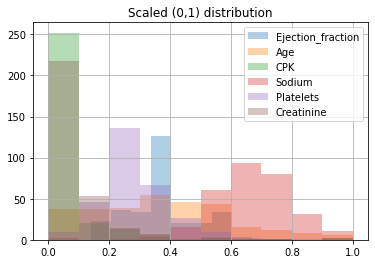

In [4]:
for i in ['Ejection_fraction','Age','CPK','Sodium','Platelets','Creatinine']:
    df[i].hist(alpha=0.35)
plt.legend(['Ejection_fraction','Age','CPK','Sodium','Platelets','Creatinine'])
plt.title('Scaled (0,1) distribution')

No Pearson correlations higher than 0.9 were found among the continuous variables, so there is no Multicollinearity between features.

,Ejection_fraction,Age,CPK,Sodium,Platelets,Creatinine
Ejection_fraction,1.000000,0.060098,-0.044080,0.175902,0.072177,-0.011302
Age,0.060098,1.000000,-0.081584,-0.045966,-0.052354,0.159187
CPK,-0.044080,-0.081584,1.000000,0.059550,0.024463,-0.016408
Sodium,0.175902,-0.045966,0.059550,1.000000,0.062125,-0.189095
Platelets,0.072177,-0.052354,0.024463,0.062125,1.000000,-0.041198
Creatinine,-0.011302,0.159187,-0.016408,-0.189095,-0.041198,1.000000


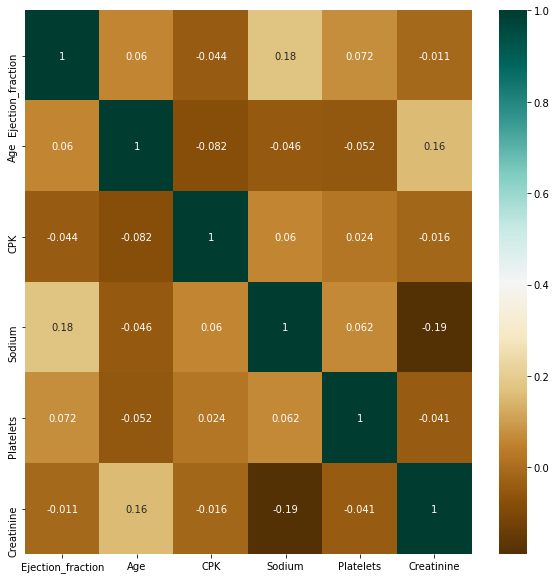

In [5]:
plt.figure(figsize=(10,10))
c=df[['Ejection_fraction','Age','CPK','Sodium','Platelets','Creatinine']].corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

### 3. Exploratory Data Analysis

##### 3.1 Relationship between target variable and categorical variables

The categorical variables add up to 4 (excluding the target variable and gender). These categorical variables describe if the patient was a smoker, if he or she developed anaemia, the presence of high blood pressure (hypertension), and if the patient had diabetes. As we can state below, **the plot bar shows the percentage (mean) of death events for each value of the dummy**.  Hence, it’s a good way to visualize if there is a huge impact of the target variable conditioning by each dummy-binary value.
The first exploratory stage showed no big differences. One may argue that smoking increases heart failure, but doesn’t mean that it causes eventually major risk to die after getting a heart failure. Same applies to diabetes. Nevertheless, the variable Anaemia and high blood pressure (Hypertension) could be good features.


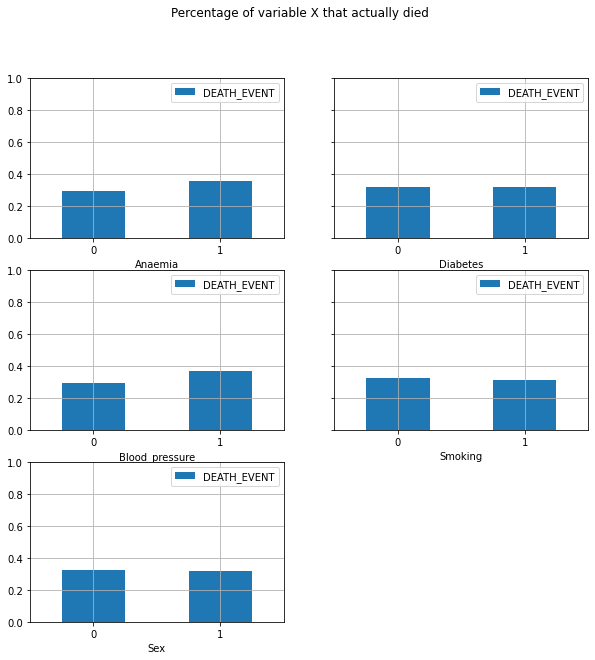

In [22]:
#Categorical variables (dummies) are O.K
fig, axes = plt.subplots(3,2,sharey=True,figsize=(10,10))
fig.suptitle('Percentage of variable X that actually died')
axes[2,1].set_axis_off()
for i,j,z in zip(['Anaemia','Diabetes','Blood_pressure','Smoking','Sex'],[0,0,1,1,2],[0,1,0,1,0]):
    
    ax=df[[i,'DEATH_EVENT']].groupby(i).mean().plot(kind='bar',ax=axes[j,z])
    
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.set_xticklabels(labels=[0,1],rotation=0) 

Additionally, ANOVA (kruskal estimation) tests were carried out in order to analyse if the differences between the means were significant.

In [7]:
dict_={'Variable':[],'P-Value':[]}
for i in ['Anaemia','Diabetes','Blood_pressure','Smoking','Sex']:
    df_anova=df[[i,'DEATH_EVENT']]
    grouped_anova = df_anova.groupby([i])
    anova_results_1 = stats.kruskal(grouped_anova.get_group(0)['DEATH_EVENT'],
                                    grouped_anova.get_group(1)['DEATH_EVENT'])  
    dict_['Variable'].append(i)
    dict_['P-Value'].append(anova_results_1.pvalue)
df_pvalues = pd.DataFrame(dict_)
df_pvalues

,Variable,P-Value
0,Anaemia,0.252624
1,Diabetes,0.973244
2,Blood_pressure,0.170746
3,Smoking,0.827500
4,Sex,0.940603


As we see, no one is statistically significant at 10%. But maybe this is caused by the small dataset, which is important in ANOVA tests. As we said, Blood pressure (lowest p-value) are kept as possible features.

##### 3.2 Relationship between target variable and continuous variables

The continuous variables are more related to technical issues. In this sense, they provide more information about the status of the patient’s heart and physical condition. Boxplots were drawn in order to analyse if there are significant differences between the variable ‘DEATH_EVENT’ and the continuous features.

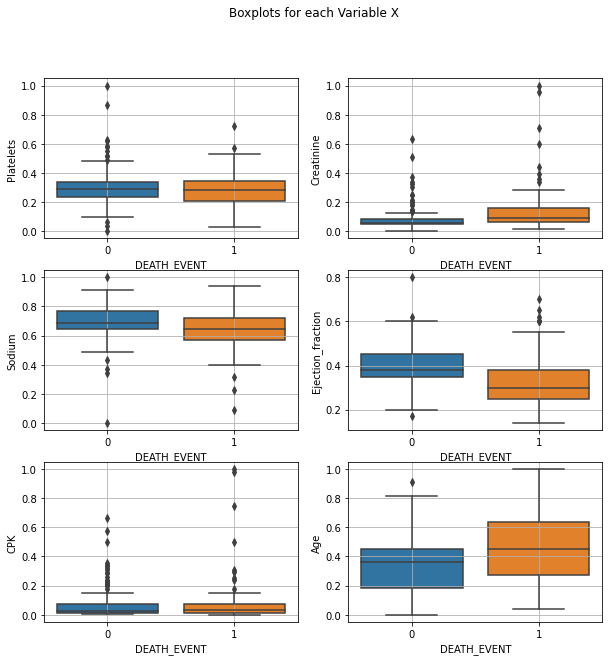

In [8]:
fig, axes = plt.subplots(3,2,figsize=(10,10))
fig.suptitle('Boxplots for each Variable X')
for i,j,z in zip(['Platelets','Creatinine','Sodium','Ejection_fraction','CPK','Age'],[0,0,1,1,2,2],[0,1,0,1,0,1]):
    ax=sns.boxplot(x='DEATH_EVENT',y=i,data=df,ax=axes[j,z])
    ax.grid(True)

Variables as ‘CPK’ and ‘Platelets’ show same distribution with patients who died and patients who not. On the other hand, variables as ‘Age’, ‘Ejection_fraction’, ‘Creatinine’ and ‘Sodium’ show more significant differences in their distributions.

##### 3.3 Proposed Machine Learning models
As the target variable is a dummy (binary), a Classification Algorithm is the most suitable choice. The Algorithms proposed are: Logistic Regression, K-nearest neighbor, and Supported Vector Machine (SVM).

### 4. Modeling and Results

Before entering the sub-sections related to each model that was used for the analysis, the features that were finally used as predictors were: Ejection_fraction, Creatinine, Age and Blood_pressure (Hypertension). Just one categorical variable was used (the one with least p-value) in order to avoid insignificant variables.
As common in Machine Learning model evaluation, a split was made between the dataset in order to train and test the model with separate datapoints. The percentage of test-set is 30 %.


In [9]:
X =np.asarray(df[['Ejection_fraction','Creatinine','Age','Blood_pressure']])
y=np.asarray(df[['DEATH_EVENT']]).ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (209, 4) (209,)
Test set: (90, 4) (90,)


##### 4.1 Logistic Regression

After fitting the model with the train set, a confusion Matrix of the test set was built and a classification report. The model seems to predict pretty well the category Death=0, but pretty bad the category Death=1. This fact is visible in the recall metric and has consequences over the F1-score metric. Finally, the Jaccard-index shows a 0.74 and the LogLoss a 0.54 metric; the former looks standard, the latter shows very bad capability in predicting.

In [10]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver='liblinear').fit(X_train,y_train)

yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

In [11]:
####CONFUSION MATRIX AND CLLASIFICATION REPORT
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
from sklearn.metrics import jaccard_similarity_score
print('The jaccard-index score is:',jaccard_similarity_score(y_test, yhat))

##log loss
from sklearn.metrics import log_loss
print('The LogLoss is:',log_loss(y_test, yhat_prob))

The jaccard-index score is: 0.7444444444444445
The LogLoss is: 0.5380111308162243


C:\Users\mrbra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


Confusion matrix, without normalization
[[ 6 21]
 [ 2 61]]
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        63
           1       0.75      0.22      0.34        27

    accuracy                           0.74        90
   macro avg       0.75      0.60      0.59        90
weighted avg       0.75      0.74      0.69        90



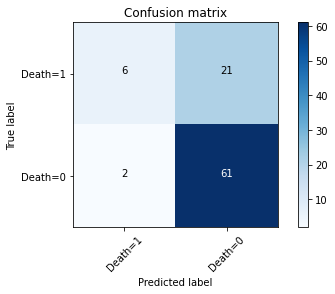

In [13]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2) 

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Death=1','Death=0'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, yhat)) 

In order to check overfitting cross validation analysis is performed:

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(LR,X,y,cv=10).mean()

0.7218984056358917

##### 4.2 K-nearest neighbor
For the K-Nearest neighbour algorithm the k parameter was estimated developing several models with different K’s and choosing the one with the highest Accuracy. Obviously the index was calculated with the test-set.

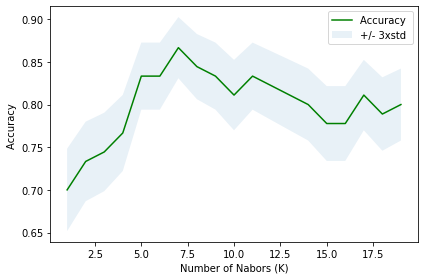

The optimal K is K=7


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn) 

    
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0]) 

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()  
print('The optimal K is K=7')

The Confusion matrix of this Machine Learning model showed much better results than the results showed by the Logistic regression model.

Confusion matrix, without normalization
[[20  7]
 [ 5 58]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        63
           1       0.80      0.74      0.77        27

    accuracy                           0.87        90
   macro avg       0.85      0.83      0.84        90
weighted avg       0.86      0.87      0.87        90

Jaccard-index score is: 0.8666666666666667


C:\Users\mrbra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


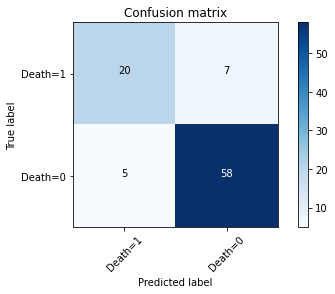

In [16]:
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

yhat_knn = neigh.predict(X_test)     

cnf_matrix_knn = confusion_matrix(y_test, yhat_knn, labels=[1,0]) 
np.set_printoptions(precision=2)  

plt.figure()
plot_confusion_matrix(cnf_matrix_knn, classes=['Death=1','Death=0'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, yhat_knn))             
print('Jaccard-index score is:',jaccard_similarity_score(y_test, yhat_knn))

Same as with the LR model we check for overfitting:

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(neigh,X,y,cv=10).mean()


0.7699147200593253

##### 4.3 Support Vector Machine (SVM)

The Support Vector Machine was constructed with a RBF kernel. The model shows bad results at predicting values with label equal to 1, but extraordinary good results at predicting values with label equal to 0. The SVM model doesn’t fit very well with small size datasets and surely this was one of the factors that made this model useless for this purpose.

Confusion matrix, without normalization
[[10 17]
 [ 4 59]]


C:\Users\mrbra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


              precision    recall  f1-score   support

           0       0.78      0.94      0.85        63
           1       0.71      0.37      0.49        27

    accuracy                           0.77        90
   macro avg       0.75      0.65      0.67        90
weighted avg       0.76      0.77      0.74        90

The Jaccard-index score is: 0.7666666666666667


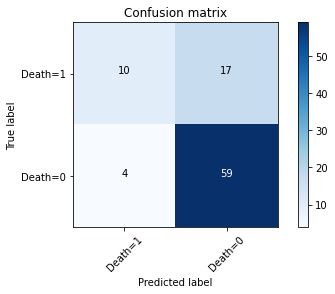

In [18]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',gamma='scale')
clf.fit(X_train, y_train) 
yhat_svm = clf.predict(X_test)  

cnf_matrix_svm = confusion_matrix(y_test, yhat_svm, labels=[1,0])        
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_svm, classes=['Death=1','Death=0'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, yhat_svm))          

print('The Jaccard-index score is:',jaccard_similarity_score(y_test, yhat_svm))  


Checking for overfitting:

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf,X,y,cv=10).mean()

0.7252169076751948

### 5. Discussion
The models displayed above (Logistic Regression,KNN,SVM) are significantly different among them. One of the key indicators that shows us this variability is the Confussion Matrix: the Logistic Regression Model and the SVM model predict very poorly the label=1 (DEATH_EVENT); in contrast KNN model predicts pretty well this label. Of course there seems to be a trade-off between the two predictions (label=0,label=1), for example, SVM model has a recall on label=0 equal to 0.94, but 0.37 on label=1. This disparity isn’t optimum.
To sum up, the best model which is perfectly equilibrated is the KNN model. The KNN model shows pretty good metrics and balanced if we compare it to the SVM model case.


### 5. Conclusion
There are severe improvements that could be made in order to achieve better results on this topic. One of these improvements is getting a better Database, as we have seen having small-size datasets makes some Algorithms useless (see the case of the SVM model). Therefore, it’s highly recommendable to perform a similar analysis but with a much larger dataset.
Additionally, the KNN model has demonstrated to be very useful with a small dataset in which the variables are clearly well defined and add signal (not noise). Distance algorithms need variables that are significantly different in order to achieve good metrics.
